# Image processing 2

* [Preprocessing](#chapter1)

* [Transfer learning, CNN](#chapter2)
    * [Fonction de creation de modèle de classification](#section_2_1)
    * [Approche avec préparation initiale des images](#section_2_3)
    * [Approche nouvelle par dataset sans augmentation](#section_2_4)
    * [Approche ImageDatagenerator avec data augmentation](#section_2_5)
    * [Approche nouvelle par Dataset avec data augmentation intégrée au modèle](#section_2_6)
        * [VGG16](#section_2_7)
        * [Inception](#section_2_8)
        * [Resnet](#section_2_9)

* [Extraction via API](#chapter3)
    


# Preprocessing <a class="anchor" id='chapter1' ></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

from google.colab import drive
import pathlib

import matplotlib.pyplot as plt

from glob import glob

from sklearn import preprocessing

In [2]:
import pandas as pd
import seaborn as sns
%matplotlib inline
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, GaussianNoise, RandomBrightness, RandomTranslation, RandomContrast

import cv2

#import splitfolders

from pathlib import Path

import shutil

#from plot_keras_history import show_history, plot_history

In [3]:
#Connecting to drive for file access
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.chdir("/content/drive/MyDrive/Flipkart-Images")
!ls

'Baby Care'			 model_VGG_DA_full_best_weights.h5
'Beauty and Personal Care'	 model_VGG_DA_hp_best_weights.h5
 Computers			 model_VGG_DA_nogaus_best_weights.h5
 grayscale			 output
'Home, Decor, & Festive Needs'	 standard.png
'Home Furnishing'		 untitled_project
'Kitchen & Dining'		 VGG_IDG_best_weights.h5
 model_VGG_DA_best_weights.h5	 Watches


In [5]:
data_dir = pathlib.Path("/content/drive/MyDrive/Flipkart-Images").with_suffix('')
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

/content/drive/MyDrive/Flipkart-Images
1890


In [6]:
data_dir_val = pathlib.Path("/content/drive/MyDrive/Flipkart-Images").with_suffix('')
print(data_dir_val)
image_count = len(list(data_dir_val.glob('*/*.jpg')))
print(image_count)

/content/drive/MyDrive/Flipkart-Images
1890


In [7]:
batch_size = 32
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2227 files belonging to 11 classes.
Using 1782 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2227 files belonging to 11 classes.
Using 445 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['.ipynb_checkpoints', 'Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Furnishing', 'Home, Decor, & Festive Needs', 'Kitchen & Dining', 'Watches', 'grayscale', 'output', 'untitled_project']


In [12]:
print(len(val_ds),len(train_ds))

14 56


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/output")
!ls

intro_to_kt  train  untitled_project  val


In [ ]:
# Get the current working directory.
current_directory = os.getcwd()

# Get a list of all the files and folders in the current directory.
files_and_folders = os.listdir(current_directory)

# Iterate over the files and folders.
for file_or_folder in files_and_folders:

  # Check if the file or folder is hidden.
  is_hidden = file_or_folder.startswith(".")

  # If the file or folder is hidden, delete it.
  if is_hidden:
    os.removedirs(os.path.join(current_directory, file_or_folder))

In [8]:
#Making classes names

list_labels = ['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home, Decor, & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [9]:
#Creating path for each images and putting iit in a dataframe column

#Label encoding classes

path = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/output/train/"
path_test = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/output/val/"

label_no_name = "no_name "

def photo_class(photo) :
    for label in list_labels :
        if label in photo[24:] :
            return label
    return label_no_name

data_path = glob(path+'*/*.jpg')
data_test_path = glob(path_test+'*/*.jpg')

def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x : photo_class(x))
    return data

data = data_fct(data_path)
data_test = data_fct(data_test_path)

le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])
# data.head(5)
data_test.head(5)

840
210


,image_path,label_name,label
0,/content/drive/MyDrive/Colab Notebooks/JD_P6_C...,Home Furnishing,3
1,/content/drive/MyDrive/Colab Notebooks/JD_P6_C...,Home Furnishing,3
2,/content/drive/MyDrive/Colab Notebooks/JD_P6_C...,Home Furnishing,3
3,/content/drive/MyDrive/Colab Notebooks/JD_P6_C...,Home Furnishing,3
4,/content/drive/MyDrive/Colab Notebooks/JD_P6_C...,Home Furnishing,3


In [ ]:
#Watching for upgrades
!pip install keras-tuner --upgrade

In [10]:
path = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/output/train/"
path_test = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/output/val/"

In [11]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [12]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [13]:
dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/output/val')
dir2 = os.listdir('/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/')
print(dir)
print(dir2)

['Home Furnishing', 'Computers', 'Beauty and Personal Care', 'Baby Care', 'Kitchen & Dining', 'Home, Decor, & Festive Needs', 'Watches', 'standard.png']
['Des_Graviers_Jean_Eudes_2_Image_Processing.ipynb', 'Des_Graviers_Jean_Eudes_2_Image_Processing-Copy1.ipynb', 'list_5_words_and_less.csv', 'unique_words.csv', 'list_10_words_and_less.csv', 'Des_Graviers_Jean_Eudes_1_Exploratory_Data_Analysis-Copy1.ipynb', 'Des_Graviers_Jean_Eudes_1_Exploratory_Data_Analysis.ipynb', '.ipynb_checkpoints', 'output', 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb', 'model1_best_weights.h5', 'model3_best_weights.h5', 'standard.png', 'model4_best_weights.h5', 'model_inception_best_weights.h5', 'model_resnet50_best_weights.h5', 'untitled_project', 'model_gray_scale_best_weights.h5', 'content', 'grayscale', 'grayscale_images', 'df_cleantext_prod.csv']


In [ ]:
#Same thing for grayscale

In [ ]:
#getting path from df

df_path = '/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/df_cleantext_prod.csv'
df = pd.read_csv(df_path)
df = df.drop('Unnamed: 0', axis = 1)

In [ ]:
# Définissez le chemin du répertoire où vous souhaitez enregistrer les copies en niveaux de gris
output_directory = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale"

# Créez le répertoire s'il n'existe pas
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Fonction pour convertir une image en niveaux de gris et enregistrer la copie
def convert_to_grayscale_and_save(input_path, output_directory):
    try:
        # Ouvrez l'image
        image = Image.open(input_path)

        # Convertissez l'image en niveaux de gris
        grayscale_image = ImageOps.grayscale(image)

        # Obtenez le nom du fichier sans le chemin
        filename = os.path.basename(input_path)

        # Créez le chemin de sortie pour la copie en niveaux de gris
        output_path = os.path.join(output_directory, filename)

        # Enregistrez l'image en niveaux de gris dans le nouveau répertoire
        grayscale_image.save(output_path)
    except Exception as e:
        print(f"Erreur lors de la conversion de {input_path}: {str(e)}")

# Parcourez vos images d'origine et créez des copies en niveaux de gris
for image_path in data["image_path"]:
    convert_to_grayscale_and_save(image_path, output_directory)

# Vous pouvez également faire la même chose pour les images de test
for image_path in data_test["image_path"]:
    convert_to_grayscale_and_save(image_path, output_directory)

In [ ]:
#image_directory= r'/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale'
#splitfolders.ratio(image_directory, output="grayscale_images",
#        seed=42, ratio=(0.8, 0.2), group_prefix=None, move=False) # default values

In [17]:
path_gray = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale_images/train"
path_gray_test = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale_images/val/"

In [ ]:
for (index, row) in df.iterrows():
    for label in list_labels:
        if row.product_cat == label:
            source_path = Path(f'/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale/{row.image}')
            destination_dir = Path(f'/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale/{label}/')

            if source_path.exists():
                if not destination_dir.exists():
                    os.makedirs(destination_dir)
                destination_path = destination_dir / row.image

                # Print statements for debugging
                print(f"Moving from: {source_path}")
                print(f"To: {destination_path}")

                # Rename and move the file
                source_path.rename(destination_path)
            else:
                print(f"Source file does not exist: {source_path}")

In [14]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale_images/")
!ls

train  val


In [15]:
# Get the current working directory.
current_directory = '/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/grayscale_images/val'

# Iterate over the files and folders in the current directory.
for file_or_folder in os.listdir(current_directory):
    # Check if the file or folder is hidden or named '.ipynb_checkpoints'.
    is_hidden = file_or_folder.startswith(".")
    is_ipynb_checkpoints = file_or_folder == ".ipynb_checkpoints"

    if is_hidden or is_ipynb_checkpoints:
        path = os.path.join(current_directory, file_or_folder)

        # Check if it's a directory (including subdirectories) and remove it recursively.
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            # If it's a file, simply remove it.
            os.remove(path)

In [18]:
dir = os.listdir(path_gray)
dir2 = os.listdir(path_gray_test)
print(dir)
print(dir2)

['Home Furnishing', 'Baby Care', 'Watches', 'Home, Decor, & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']
['Home Furnishing', 'Baby Care', 'Watches', 'Home, Decor, & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


In [19]:
dataset_gray_train = dataset_fct(path_gray, validation_split=0.25, data_type='training')
dataset_gray_val = dataset_fct(path_gray, validation_split=0.25, data_type='validation')
dataset_gray_test = dataset_fct(path_gray_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


# Etape 2 : Transfer learning <a class="anchor" id='chapter5' ></a>

3 approches sont présentées :

* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée

* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation

* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

##Fonctions de creation des models de classification <a class="anchor" id='section_2_1' ></a>

In [14]:
# Sans data augmentation

def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné / freeze
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

In [15]:
# Avec data augmentation
def create_model_fct2(model_base=None, size=256):
    if model_base is None:
        model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    data_augmentation = Sequential([
        RandomFlip(mode='horizontal', input_shape=(224, 224, 3)),
        tf.keras.layers.RandomContrast(0.5),
        tf.keras.layers.RandomCrop(height=150, width=150),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomHeight(0.5),
        tf.keras.layers.RandomWidth(0.1),
        tf.keras.layers.RandomZoom(0.9),
        tf.keras.layers.RandomTranslation(height_factor=0.9,width_factor=0.9),
        RandomBrightness(0.2),  # Random Brightness Adjustment
        GaussianNoise(0.1) #
        # Rescaling(1./127.5, offset=-1.0)
        ])

    # Récupération modèle pré-entraîné
    # model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(size, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model

In [16]:
def create_model_fct_klayers(model_base=None, size=256, INPUT_SHAPE = (224, 224, 3)) :

    if model_base == None:
        model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))


    # Récupération modèle pré-entraîné
    for layer in model_base.layers:
      layer.trainable = False

    data_augmentation = Sequential([
        RandomFlip(mode='horizontal', input_shape=(224, 224, 3)),
        tf.keras.layers.RandomContrast(0.5),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.9),
        tf.keras.layers.RandomTranslation(height_factor=0.9,width_factor=0.9),
        #RandomBrightness(0.2),  # Random Brightness Adjustment
        #GaussianNoise(0.1)
        # Rescaling(1./127.5, offset=-1.0)
        ])

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])
    model.build(input_shape=(None, 224, 224, 3))

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    model.summary()

    return model

In [27]:
def create_model_fct_klayers_hp(hp, model_base=None, size=256, INPUT_SHAPE = (224, 224, 3)) :

    if model_base is None:
        model_base = VGG16(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)

    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip(mode='horizontal', input_shape=INPUT_SHAPE),
        tf.keras.layers.RandomContrast(0.5),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.9),
        tf.keras.layers.RandomTranslation(height_factor=0.9,width_factor=0.9),
        RandomBrightness(0.2),  # Random Brightness Adjustment
        GaussianNoise(0.1) #
        # Rescaling(1./127.5, offset=-1.0)
        ])

    # Récupération modèle pré-entraîné
    for layer in model_base.layers:
        layer.trainable = False


    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D()])

    model.add(layers.Dense(units = hp.Int("units", min_value=32, max_value = 1024, step=32), activation=hp.Choice("activation",["relu","gelu"])))

    #if hp.Boolean("dropout"):
      #model.add(layers(Dropout(rate = 0.25)))

    model.add(layers.Dense(7, activation = 'softmax'))

    learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

    print(model.summary())

    return model

In [45]:
def create_model_fct_gray():
    # Load the pre-trained VGG16 model
    base_model = VGG16(include_top=False, weights="imagenet")

    # Layer non entraînables = on garde les poids du modèle pré-entraîné / freeze
    for layer in base_model.layers:
        layer.trainable = False

    # Define the input layer for grayscale images
    #input_layer = Input(shape=(224, 224, 1))

    # Preprocess input using VGG16 preprocessing (mean subtraction)
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = preprocess_input(x)

    # Pass the preprocessed input through the base model
    x = base_model(x, training=False)

    # Complete the model
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Define the new model
    model = Model(inputs=i, outputs=predictions)

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


In [58]:
def create_model_fct_klayers_gray(model_base=None):
    if model_base is None:
        model_base = VGG16(include_top=False, weights="imagenet")

    # Récupération modèle pré-entraîné
    for layer in model_base.layers:
        layer.trainable = False

    data_augmentation = [
        RandomFlip(mode='horizontal'),
        tf.keras.layers.RandomContrast(0.5),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.9),
        tf.keras.layers.RandomTranslation(height_factor=0.9, width_factor=0.9),
        RandomBrightness(0.2),  # Random Brightness Adjustment
        GaussianNoise(0.1)
        # Rescaling(1./127.5, offset=-1.0)
    ]
       # Custom input preprocessing layer
    input_layer = tf.keras.layers.Input([None, None, 3], dtype=tf.uint8)
    x = tf.cast(input_layer, tf.float32)
    x = preprocess_input(x)  # Preprocess the input with VGG16 preprocessing
    # Construct the model layers
    for layer in data_augmentation:
        x = layer(x)

    x = Rescaling(1./127.5, offset=-1)(x)
    x = model_base(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(7, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    model.summary()

    return model


## Approche avec preparation initiale des images <a class="anchor" id='section_2_2' ></a>

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        display(img)
        print(img)
        print('-----------------------')
        im2 = ImageOps.grayscale(img)
        display(im2)
        print(im2)
        stop

images_np = image_prep_fct(data)

In [ ]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


## Approche nouvelle par Dataset sans data augmentation <a class="anchor" id='section_2_3' ></a>

CF https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
with tf.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 7.7895 - accuracy: 0.4095 
Epoch 1: val_loss improved from inf to 1.64768, saving model to ./model3_best_weights.h5
20/20 [==============================] - 486s 24s/step - loss: 7.7895 - accuracy: 0.4095 - val_loss: 1.6477 - val_accuracy: 0.7381
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.4917 - accuracy: 0.6429 
Epoch 2: val_loss improved from 1.64768 to 1.31558, saving model to ./model3_best_weights.h5
20/20 [==============================] - 485s 24s/step - loss: 2.4917 - accuracy: 0.6429 - val_loss: 1.3156 - val_accuracy: 0.7286
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.5102 - accuracy: 0.7302 
Epoch 3: val_loss improved from 1.31558 to 1.07623, saving model to ./model3_best_weights.h5
20/20 [==============================] - 485s 24s/step - loss: 1.5102 - accuracy: 0.7302 - val_loss: 1.0762 - val_accuracy: 0.7952
Epoch 4/50
20/20 [=============================

In [ ]:
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 341s 17s/step - loss: 0.0045 - accuracy: 1.0000
Training Accuracy   : 1.0000

7/7 [==============================] - 114s 16s/step - loss: 1.0453 - accuracy: 0.8143
Validation Accuracy :  0.8143


In [ ]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche ImageDatagenerator avec data augmentation <a class="anchor" id='section_2_4' ></a>

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    VGG_IDG = create_model_fct()

# Création du callback
VGG_IDG_save_path = "./VGG_IDG_best_weights.h5"
checkpoint = ModelCheckpoint(VGG_IDG_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
with tf.device('/gpu:0'):
    history_VGG_IDG = VGG_IDG.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle <a class="anchor" id='section_2_5' ></a>

CF https://www.tensorflow.org/tutorials/images/data_augmentation

Nous allons effectuer la data augmentation de plusieurs manières:

1. Avec Random Flip, Random Contrast, Random rotation, Random Zoom, Random Translation

2. En ajoutant Random Brightness, Gaussian Noise

3. En changeant nos images en Gray Scale

Nous éssaierons 3 architectures de transfer learning entrainées sur Imagenet : VGG16, Inception et Resnet.

Après quoi nous chercherons à optimiser les hyperparamètres des architectures avec une Recherche aléatoire et une optimisation Bayésienne.


#VGG 16 <a class="anchor" id='section_2_6' ></a>

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model_VGG_DA = create_model_fct_klayers()

# Création du callback
model_VGG_DA_save_path = "./model_VGG_DA_best_weights.h5"
checkpoint = ModelCheckpoint(model_VGG_DA_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_112 (Sequential  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 rescaling_52 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
 8 (GlobalAveragePooling2D)                                      
                                                                 
 dense_114 (Dense)           (None, 256)               131328    
                                                                 
 dropout_57 (Dropout)        (None, 256)            

In [ ]:
with tf.device('/gpu:0'):
    history_VGG_DA = model_VGG_DA.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.7748 - accuracy: 0.3413 
Epoch 1: val_loss improved from inf to 1.35141, saving model to ./model_VGG_DA_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 474s 24s/step - loss: 1.7748 - accuracy: 0.3413 - val_loss: 1.3514 - val_accuracy: 0.7000
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.3210 - accuracy: 0.5778 
Epoch 2: val_loss improved from 1.35141 to 0.99371, saving model to ./model_VGG_DA_best_weights.h5
20/20 [==============================] - 492s 25s/step - loss: 1.3210 - accuracy: 0.5778 - val_loss: 0.9937 - val_accuracy: 0.7667
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.0190 - accuracy: 0.6937 
Epoch 3: val_loss improved from 0.99371 to 0.85980, saving model to ./model_VGG_DA_best_weights.h5
20/20 [==============================] - 492s 25s/step - loss: 1.0190 - accuracy: 0.6937 - val_loss: 0.8598 - val_accuracy: 0.7810
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.9054 - accuracy: 0.6984 
Epoch 4: val_loss improved from 0.85980 to 0.74911, saving model to ./model_VGG_DA_best_weights.h5
20/20 [==================

In [ ]:
loss, accuracy = model_VGG_DA.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_VGG_DA.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 401s 19s/step - loss: 0.3023 - accuracy: 0.9079
Training Accuracy   : 0.9079

7/7 [==============================] - 115s 16s/step - loss: 0.5345 - accuracy: 0.8381
Validation Accuracy :  0.8381


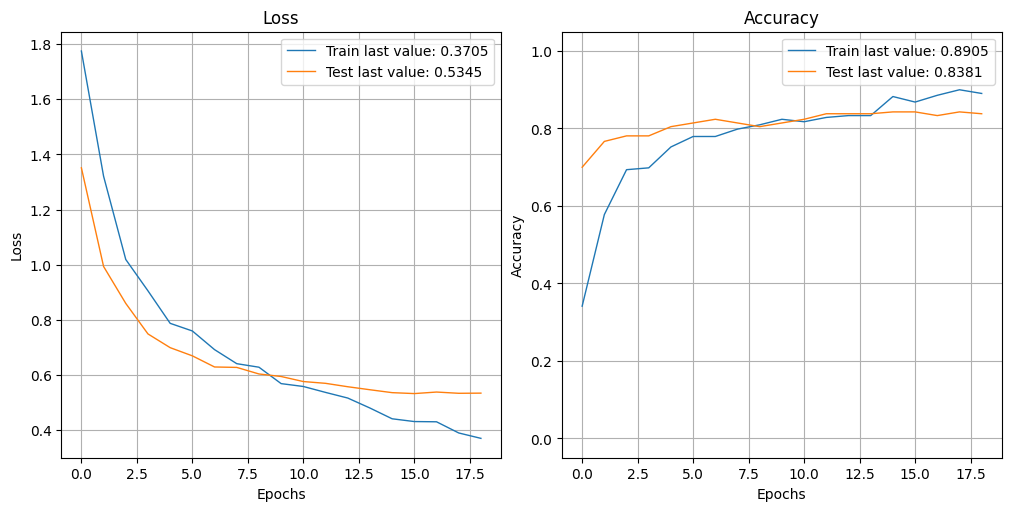

In [ ]:
show_history(history_VGG_DA)
plot_history(history_VGG_DA, path="standard.png")
plt.close()

In [88]:
# Création du modèle avec toutes les couches de data augmentation

with tf.device('/gpu:0'):
    model_VGG_DA_full = create_model_fct_klayers()

# Création du callback
model_VGG_DA_full_save_path = "./model_VGG_DA_full_best_weights.h5"
checkpoint = ModelCheckpoint(model_VGG_DA_full_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_67 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_37 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
 8 (GlobalAveragePooling2D)                                      
                                                                 
 dense_74 (Dense)            (None, 256)               131328    
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                     

In [ ]:
with tf.device('/gpu:0'):
    history_VGG_DA_full = model_VGG_DA_full.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.0026 - accuracy: 0.1841 
Epoch 1: val_loss improved from inf to 1.68920, saving model to ./model_VGG_DA_full_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 614s 31s/step - loss: 2.0026 - accuracy: 0.1841 - val_loss: 1.6892 - val_accuracy: 0.3476
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.7642 - accuracy: 0.3175 
Epoch 2: val_loss improved from 1.68920 to 1.46980, saving model to ./model_VGG_DA_full_best_weights.h5
20/20 [==============================] - 589s 30s/step - loss: 1.7642 - accuracy: 0.3175 - val_loss: 1.4698 - val_accuracy: 0.5238
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.6110 - accuracy: 0.4286 
Epoch 3: val_loss improved from 1.46980 to 1.30770, saving model to ./model_VGG_DA_full_best_weights.h5
20/20 [==============================] - 563s 28s/step - loss: 1.6110 - accuracy: 0.4286 - val_loss: 1.3077 - val_accuracy: 0.5190
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 1.5173 - accuracy: 0.4540 
Epoch 4: val_loss improved from 1.30770 to 1.18669, saving model to ./model_VGG_DA_full_best_weights.h5
20/20 [===

In [22]:
# Création du modèle sans les couches de data augmentation bruit gaussien

with tf.device('/gpu:0'):
    model_VGG_DA_nogaus = create_model_fct_klayers()

# Création du callback
model_VGG_DA_nogaus_save_path = "./model_VGG_DA_nogaus_best_weights.h5"
checkpoint = ModelCheckpoint(model_VGG_DA_nogaus_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               

In [23]:
with tf.device('/gpu:0'):
    history_VGG_DA_nogaus = model_VGG_DA_nogaus.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.0785 - accuracy: 0.1841 
Epoch 1: val_loss improved from inf to 1.65353, saving model to ./model_VGG_DA_nogaus_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 640s 29s/step - loss: 2.0785 - accuracy: 0.1841 - val_loss: 1.6535 - val_accuracy: 0.4714
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.7759 - accuracy: 0.2984 
Epoch 2: val_loss improved from 1.65353 to 1.54874, saving model to ./model_VGG_DA_nogaus_best_weights.h5
20/20 [==============================] - 542s 27s/step - loss: 1.7759 - accuracy: 0.2984 - val_loss: 1.5487 - val_accuracy: 0.4619
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.6714 - accuracy: 0.3778 
Epoch 3: val_loss improved from 1.54874 to 1.29217, saving model to ./model_VGG_DA_nogaus_best_weights.h5
20/20 [==============================] - 552s 28s/step - loss: 1.6714 - accuracy: 0.3778 - val_loss: 1.2922 - val_accuracy: 0.6619
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 1.4812 - accuracy: 0.4730 
Epoch 4: val_loss improved from 1.29217 to 1.15907, saving model to ./model_VGG_DA_nogaus_best_weights.h5
20/2

In [ ]:
# Grayscale Images

In [47]:
with tf.device('/gpu:0'):
    model_gray = create_model_fct_gray()

# Création du callback
model_gray_save_path = "./model_VGG_gray_weights.h5"
checkpoint = ModelCheckpoint(model_gray_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

history_model_gray = model_gray.fit(dataset_gray_train,
                    validation_data=dataset_gray_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 tf.cast_7 (TFOpLambda)      (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_6  (None, None, None, 3)     0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_6 (TFOpLamb  (None, None, None, 3)     0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.5777 - accuracy: 0.6857 
Epoch 2: val_loss improved from 1.21536 to 0.88409, saving model to ./model_VGG_gray_weights.h5
20/20 [==============================] - 490s 25s/step - loss: 1.5777 - accuracy: 0.6857 - val_loss: 0.8841 - val_accuracy: 0.7667
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.7556 
Epoch 3: val_loss improved from 0.88409 to 0.84959, saving model to ./model_VGG_gray_weights.h5
20/20 [==============================] - 490s 25s/step - loss: 1.0983 - accuracy: 0.7556 - val_loss: 0.8496 - val_accuracy: 0.7857
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.8000 
Epoch 4: val_loss improved from 0.84959 to 0.80204, saving model to ./model_VGG_gray_weights.h5
20/20 [==============================] - 456s 23s/step - loss: 0.6834 - accuracy: 0.8000 - val_loss: 0.8020 - val_accuracy: 0.7619
Epoch 5/50
20/20 [================

In [ ]:
with tf.device('/gpu:0'):
    model_gray_DA = create_model_fct_klayers_gray()

# Création du callback
model_gray_DA_save_path = "./model_VGG_gray_DA_weights.h5"
checkpoint = ModelCheckpoint(model_gray_DA_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

history_model_gray_DA = model_gray_DA.fit(dataset_gray_train,
                    validation_data=dataset_gray_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 tf.cast_14 (TFOpLambda)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_1  (None, None, None, 3)     0         
 3 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_13 (TFOpLam  (None, None, None, 3)     0         
 bda)                                                            
                                                                 
 random_flip_6 (RandomFlip)  (None, None, None, 3)     0         
                                                                 
 random_contrast_6 (RandomC  (None, None, None, 3)     0  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.8685 - accuracy: 0.2619 
Epoch 2: val_loss improved from 1.65198 to 1.53149, saving model to ./model_VGG_gray_DA_weights.h5
20/20 [==============================] - 495s 25s/step - loss: 1.8685 - accuracy: 0.2619 - val_loss: 1.5315 - val_accuracy: 0.4333
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.7020 - accuracy: 0.3810 
Epoch 3: val_loss improved from 1.53149 to 1.40159, saving model to ./model_VGG_gray_DA_weights.h5
20/20 [==============================] - 474s 24s/step - loss: 1.7020 - accuracy: 0.3810 - val_loss: 1.4016 - val_accuracy: 0.4762
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 1.6572 - accuracy: 0.3667 
Epoch 4: val_loss improved from 1.40159 to 1.34245, saving model to ./model_VGG_gray_DA_weights.h5
20/20 [==============================] - 471s 24s/step - loss: 1.6572 - accuracy: 0.3667 - val_loss: 1.3424 - val_accuracy: 0.5190
Epoch 5/50
20/20 [=======

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-6f2b0a5761ec>", line 10, in <cell line: 10>
    history_model_gray_DA = model_gray_DA.fit(dataset_gray_train,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 513, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.FailedPreconditionError: . is not a directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = valu

In [28]:
#Hyperparemeters tuning sur VGG16

import kerastuner as kt

# Création du modèle
with tf.device('/gpu:0'):
    model_VGG_hp = create_model_fct_klayers_hp(kt.HyperParameters())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                      

In [23]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(create_model_fct_klayers_hp,
objective='val_accuracy',
max_epochs=10,
factor=3,
overwrite=True)

callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                         mode='min',
                                         patience=3,
                                         restore_best_weights=True)]

tuner.search(dataset_train,
             validation_data=dataset_test,
             callbacks=callbacks,
             verbose=1,
             epochs=10)

tuner.results_summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 32)                16416     
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                      

In [29]:
tuner = kt.RandomSearch(
      create_model_fct_klayers_hp,
      objective='val_loss',
      max_trials=10)

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                         mode='min',
                                         patience=3,
                                         restore_best_weights=True)]

tuner.search(dataset_train,
             validation_data=dataset_test,
             callbacks=callbacks,
             verbose=1,
             epochs=10)

tuner.results_summary()

Trial 4 Complete [01h 32m 41s]
val_loss: 0.7612987756729126

Best val_loss So Far: 0.6571428775787354
Total elapsed time: 01h 32m 41s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
224               |704               |units
relu              |gelu              |activation
True              |False             |dropout
0.00035633        |0.00092653        |lr

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               

#Inception <a class="anchor" id='section_2_7' ></a>

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

# create the base pre-trained model. Exclude the top !!
model_inception = InceptionV3(weights='imagenet', include_top=False)

for i, layer in enumerate(model_inception.layers):
    print (i, layer.name, layer.output_shape)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model_inception = create_model_fct2(InceptionV3(weights='imagenet', include_top=False),1024)

# Création du callback
model_inception_save_path = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_inception_best_weights.h5"
checkpoint = ModelCheckpoint(model_inception_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_62 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_27 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_64 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_32 (Dropout)        (None, 1024)            

In [ ]:
with tf.device('/gpu:0'):
    history_inception = model_inception.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.3222 - accuracy: 0.4508
Epoch 1: val_loss improved from inf to 0.86560, saving model to /content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_inception_best_weights.h5
20/20 [==============================] - 205s 8s/step - loss: 2.3222 - accuracy: 0.4508 - val_loss: 0.8656 - val_accuracy: 0.7048
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.8954 - accuracy: 0.7079
Epoch 2: val_loss improved from 0.86560 to 0.59091, saving model to /content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_inception_best_weights.h5
20/20 [==============================] - 151s 7s/step - loss: 0.8954 - accuracy: 0.7079 - val_

In [ ]:
loss, accuracy = model_inception.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_inception.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 94s 4s/step - loss: 0.2503 - accuracy: 0.9143
Training Accuracy   : 0.9143

7/7 [==============================] - 31s 4s/step - loss: 0.7413 - accuracy: 0.7619
Validation Accuracy :  0.7619


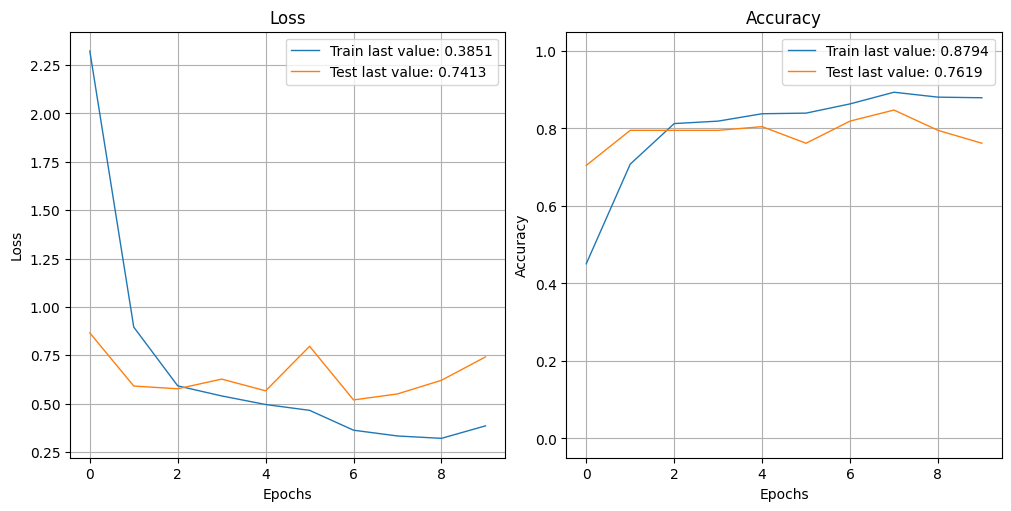

In [ ]:
show_history(history_inception)
plot_history(history_inception, path="standard.png")
plt.close()

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model_inception_DA = create_model_fct_klayers()

# Création du callback
model_inception_DA_save_path = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_inception_DA_best_weights.h5"
checkpoint = ModelCheckpoint(model_inception_DA_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

with tf.device('/gpu:0'):
    history_inception_augmented = model_inception_DA.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 257s 10s/step - loss: 1.4788 - accuracy: 0.5810 - val_loss: 0.7954 - val_accuracy: 0.7381
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.7905
Epoch 2: val_loss improved from 0.79540 to 0.71522, saving model to /content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_inception_DA_best_weights.h5
20/20 [==============================] - 106s 5s/step - loss: 0.7678 - accuracy: 0.7905 - val_loss: 0.7152 - val_accuracy: 0.7810
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.8111
Epoch 3: val_loss did not improve from 0.71522
20/20 [==============================] - 103s 5s/step - loss: 0.5637 - accuracy: 0.8111 - val_loss: 0.9889 - val_accuracy: 0.7238
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.3571 

In [ ]:
loss, accuracy = model_inception_DA.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_inception_DA.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 90s 4s/step - loss: 0.0806 - accuracy: 0.9762
Training Accuracy   : 0.9762

7/7 [==============================] - 39s 5s/step - loss: 0.5763 - accuracy: 0.8429
Validation Accuracy :  0.8429


In [ ]:
with tf.device('/gpu:0'):
    history_inception_DA = model_inception_DA.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

In [ ]:
create_model_fct_klayers_hp(kt.HyperParameters())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                16416     
                                                                 
 dense_10 (Dense)            (None, 7)                 231       
                                                     

In [ ]:
show_history(history_inception_augmented)
plot_history(history_inception_augmented, path="standard.png")
plt.close()

In [ ]:
create_model_fct_klayers_hp(kt.HyperParameters(),model_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 32)                65568     
                                                                 
 dense_6 (Dense)             (None, 7)                 231       
                                                      

In [ ]:
tuner = kt.RandomSearch(
      create_model_fct_klayers_hp,
      objective='val_loss',
      max_trials=10)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 32)                65568     
                                                                 
 dense_9 (Dense)             (None, 7)                 231       
                                                     

In [ ]:
tuner.search(dataset_train, epochs=5, validation_data = dataset_val, verbose = 1)

Trial 10 Complete [00h 00m 06s]

Best val_loss So Far: 0.5331029891967773
Total elapsed time: 00h 42m 46s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('lr')}, and the optimal activation function is {best_hps.get('activation')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.0003975834555321742, and the optimal activation function is relu.



In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model_inception_DA_hps = create_model_fct_klayers_hp(best_hps)

# Création du callback
model_inception_DA_hps_save_path = "./model_inception_DA_hp_best_weights.h5"
checkpoint = ModelCheckpoint(model_VGG_DA_hps_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 480)               983520    
                                                                 
 dense_2 (Dense)             (None, 7)                 3367      
                                                      

#Resnet <a class="anchor" id='section_2_8' ></a>

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50


# create the base pre-trained model. Exclude the top !!
model_resnet = ResNet50(weights='imagenet', include_top=False)

for i, layer in enumerate(model_resnet.layers):
    print (i, layer.name, layer.output_shape)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model_resnet = create_model_fct2(ResNet50(weights='imagenet', include_top=False),1024)

# Création du callback
model_resnet_save_path = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_resnet50_best_weights.h5"
checkpoint = ModelCheckpoint(model_resnet_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                      

In [ ]:
with tf.device('/gpu:0'):
    history_resnet = model_resnet.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.0671 - accuracy: 0.2302
Epoch 1: val_loss improved from inf to 1.74742, saving model to /content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_resnet50_best_weights.h5
20/20 [==============================] - 239s 12s/step - loss: 2.0671 - accuracy: 0.2302 - val_loss: 1.7474 - val_accuracy: 0.2952
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.7536 - accuracy: 0.3333
Epoch 2: val_loss improved from 1.74742 to 1.72126, saving model to /content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_resnet50_best_weights.h5
20/20 [==============================] - 236s 12s/step - loss: 1.7536 - accuracy: 0.3333 - val_

In [ ]:
loss, accuracy = model_resnet.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model_resnet.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 168s 7s/step - loss: 1.3192 - accuracy: 0.4857
Training Accuracy   : 0.4857

7/7 [==============================] - 49s 6s/step - loss: 1.6474 - accuracy: 0.3714
Validation Accuracy :  0.3714


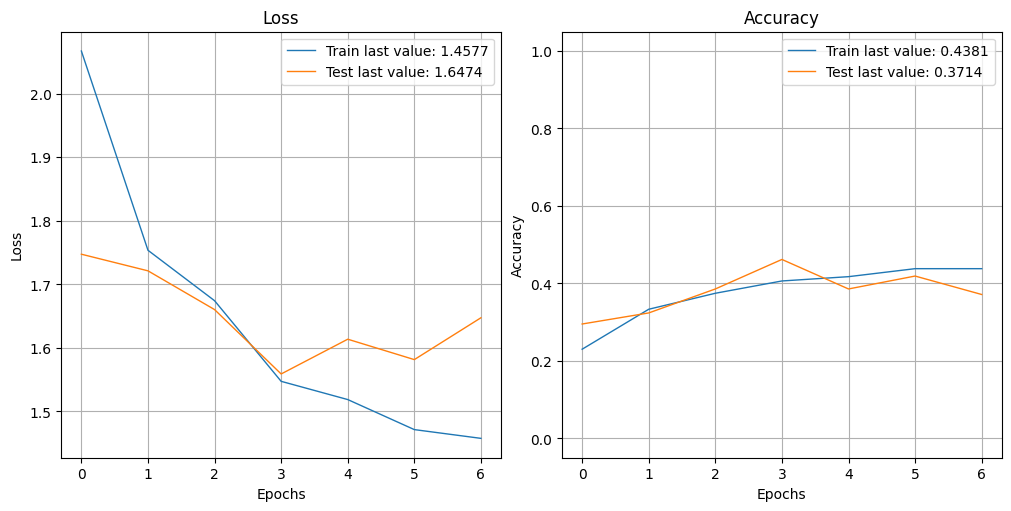

In [ ]:
show_history(history_resnet)
plot_history(history_resnet, path="standard.png")
plt.close()

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model_resnet_DA = create_model_fct_klayers(ResNet50(weights='imagenet', include_top=False),1024)

# Création du callback
model_resnet_DA_save_path = "/content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_resnet50_DA_best_weights.h5"
checkpoint = ModelCheckpoint(model_resnet_DA_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                      

In [ ]:
with tf.device('/gpu:0'):
    history_resnet_DA = model_resnet_DA.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.6634 - accuracy: 0.5651
Epoch 1: val_loss improved from inf to 0.66168, saving model to /content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_resnet50_DA_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 119s 5s/step - loss: 1.6634 - accuracy: 0.5651 - val_loss: 0.6617 - val_accuracy: 0.7762
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.8143
Epoch 2: val_loss did not improve from 0.66168
20/20 [==============================] - 121s 6s/step - loss: 0.6526 - accuracy: 0.8143 - val_loss: 0.6667 - val_accuracy: 0.7905
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.8222
Epoch 3: val_loss improved from 0.66168 to 0.58632, saving model to /content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation//content/drive/MyDrive/Colab Notebooks/JD_P6_Classifier_automatiquement_des_biens_de_consommation/model_resnet50_DA_best_weights.h5
20/20 [==============================] - 107s 5s/step - loss: 0.5299 - accuracy: 0.8222 - val_loss: 0.5863 - val_accuracy: 0.8000
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.3245 - 

L'approche transfer learning utilisée avec des modèles entrainés sur imagenet permet de bons résultats de classification sur notre jeu de données.

Les differentes architectures donnent des résultats assez similaires.

On remarque que les performances sont moins bonnes sans data augmentation.

Il est aussi necessaire d'optimiser les hyperparametres pour de meilleurs résultats.

##API Extraction <a class="anchor" id='chapter_3' ></a>

Il est demandé d'extraire une liste de produits à partir d'une API. Le code suivant permet l'extraction et l'enregistrement dans un fichier csv.

In [ ]:
url = 'https://edamam-food-and-grocery-database.p.rapidapi.com/api/food-database/v2/parser?ingr=champagne'

headers = {
    'X-RapidAPI-Key': '5bad54d654msh99a5b3c645ff106p111cb4jsnf47f3b7d863c',
    'X-RapidAPI-Host': 'edamam-food-and-grocery-database.p.rapidapi.com'
}

try:
    response = requests.get(url, headers=headers)
    response_data = response.json()
    hints_list = response_data['hints']

    # Create lists to store the extracted data
    food_ids = []
    labels = []
    categories = []
    images = []
    food_contents_labels = []

    # Loop through the list of hints and extract data
    for item in hints_list:
        food_info = item["food"]
        food_ids.append(food_info["foodId"])
        labels.append(food_info["label"])
        categories.append(food_info["category"])
        images.append(food_info.get("image"))
        food_contents_labels.append(food_info.get("foodContentsLabel"))

    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        "Food ID": food_ids,
        "Label": labels,
        "Category": categories,
        "Image": images,
        "Food Content Label": food_contents_labels
    })

    # Save the DataFrame as a CSV file
    df.to_csv("food_data.csv", index=False)

    print("Data saved as 'food_data.csv'")

except Exception as e:
    print("Exception:", e)